In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
from scipy.spatial import cKDTree
import ili
from ili.inference import InferenceRunner
from ili.embedding import GraphNetwork
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.dataloaders import TorchLoader

from typing import *
from pathlib import Path

from torch_geometric.data import Data, Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader.dataloader import Collater

from getdist import plots, MCSamples

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [2]:
%matplotlib inline

In [3]:
def load_parameters(
    data_dir, param_file: str, nodes: List[int], param_names: List[str]
) -> np.array:
    """Get parameters for nodes

    Args:
        param_file (str): where to find parameters of latin hypercube
        nodes (List[int]): list of nodes to read
        param_names (List[str]): parameters to use

    Returns:
        np.array: array of parameters
    """
    theta = pd.read_csv(data_dir / param_file, sep=" ", skipinitialspace=True).iloc[
        nodes
    ]
    return theta[param_names].values


import readfof


def load_sim(
    node: int,
    redshift: float,
    path_to_lhcs: Path,
) -> Tuple[np.array, np.array, np.array]:
    """load quijote simulationsn from latin hypercube

    Args:
        node (int): node to read
        redshift (float): redshift to read
        path_to_lhcs (_type_, optional): Path to where latin hypercubes are stored.

    Returns:
        pos (np.array): array of halo positions (in Mpc/h)
        vel (np.array): array of halo velocities (in km/s)
        mass (np.array): array of halo masses (in Msun/h)
    """
    snapshot_dict = {0.0: 4, 0.5: 3, 1.0: 2, 2.0: 1, 3.0: 0}
    FoF = readfof.FoF_catalog(
        str(path_to_lhcs / f"{node}/"),
        snapshot_dict[redshift],
        long_ids=False,
        swap=False,
        SFR=False,
        read_IDs=False,
    )
    pos = FoF.GroupPos / 1e3
    vel = FoF.GroupVel * (1.0 + redshift)
    mass = FoF.GroupMass * 1e10
    return pos, vel, mass


def get_halo_positions(
    path_to_lhcs,
    nodes: List[int],
    redshift=0.0,
    n_halos=1_000,
) -> np.array:
    positions = []
    for node in nodes:
        pos, vel, mass = load_sim(
            node=node, redshift=redshift, path_to_lhcs=path_to_lhcs
        )
        sorted_mass_idx = np.argsort(mass)
        pos = pos[sorted_mass_idx][-n_halos:, :]
        positions.append(pos)
    return np.array(positions)

In [4]:
class GraphDataset(Dataset):
    def __init__(
        self,
        positions,
        theta,
        boxsize,
        radius,
    ):
        super().__init__()
        self.positions = torch.Tensor(positions.astype(np.float32))
        self.theta = torch.Tensor(theta.astype(np.float32))
        self.boxsize = boxsize
        self.radius = radius
        self.data_list = self.process_positions()

    def process_positions(self):
        data_list = []
        for idx, pos in enumerate(self.positions):
            pos %= self.boxsize
            tree = cKDTree(pos, boxsize=self.boxsize)
            neighbors = tree.query_ball_tree(tree, r=self.radius)
            # Generate edge pairs (i, j), remove self loops
            edge_index = [
                (i, j)
                for i, neighbors_i in enumerate(neighbors)
                for j in neighbors_i
                if i != j
            ]
            edge_index = torch.tensor(edge_index, dtype=torch.int64).T
            dr = pos[edge_index[0]] - pos[edge_index[1]]
            # correct with periodic boundary conditions
            dr = (dr + self.boxsize / 2) % self.boxsize - self.boxsize / 2
            d = torch.sqrt(torch.sum(dr**2, axis=1))
            edge_attr = torch.hstack((dr, d.unsqueeze(1)))
            edge_attr /= self.radius
            data = Data(edge_attr=edge_attr, edge_index=edge_index, y=self.theta[idx])
            data_list.append(data)
        return data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        data = self.data_list[idx]
        return data, data.y

In [5]:
# *** Hyperparameters
radius = 20.0
batch_size = 32
summary_dim = 200
gnn_hidden_dims = 128
n_message_passing_steps = 2
n_hidden_density_estimator = 50
n_transforms_density_estimator = 5
n_density_estimators = 1

train_args = {
    "training_batch_size": batch_size,
    "learning_rate": 2e-4,
    "stop_after_epochs": 150,
    "max_epochs": 300,
}

# *** Dataset
n_halos = 10_000
train_nodes = range(1800)
val_nodes = range(1800, 2000)
test_nodes = [
    1154,
    1945,
]



In [6]:

# *** Loading data 
data_dir = Path(
    "/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/quijote/latin_hypercube/"
)
param_file = "latin_hypercube_params.txt"
param_names = ["Omega_m", "sigma_8"]
boxsize = 1000.0
train_nodes = [node for node in train_nodes if node not in test_nodes]
val_nodes = [node for node in val_nodes if node not in test_nodes]
train_positions = get_halo_positions(
    data_dir,
    nodes=train_nodes,
    n_halos=n_halos,
)
train_theta = load_parameters(
    data_dir, param_file=param_file, nodes=train_nodes, param_names=param_names
)

val_positions = get_halo_positions(
    data_dir,
    nodes=val_nodes,
    n_halos=n_halos,
)
val_theta = load_parameters(
    data_dir, nodes=val_nodes, param_file=param_file, param_names=param_names
)

test_positions = get_halo_positions(
    data_dir,
    nodes=test_nodes,
    n_halos=n_halos,
)
test_theta = load_parameters(
    data_dir, param_file=param_file, nodes=test_nodes, param_names=param_names
)
train_dataset = GraphDataset(train_positions, train_theta, boxsize, radius)
val_dataset = GraphDataset(val_positions, val_theta, boxsize, radius)
test_dataset = GraphDataset(test_positions, test_theta, boxsize, radius)

In [7]:
len(train_dataset), len(val_dataset)

(1799, 199)

In [8]:
collater = Collater(train_dataset[0])


# output (input, output) pairs
def collate_fn(batch):
    return collater(batch)


train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)
loader = TorchLoader(train_loader, val_loader)

In [9]:
model = GraphNetwork(
    node_features_dim=None,
    edge_features_dim=4,
    node_features_hidden_dim=gnn_hidden_dims,
    edge_features_hidden_dim=gnn_hidden_dims,
    global_output_dim=summary_dim,
    message_passing_steps=n_message_passing_steps,
)
model = model.to(device)

In [10]:
nets = [
    ili.utils.load_nde_lampe(
        model="maf",
        hidden_features=n_hidden_density_estimator,
        num_transforms=n_transforms_density_estimator,
        embedding_net=model,
        x_normalize=False,
    ) for _ in range(n_density_estimators)
]


In [11]:
prior = ili.utils.Uniform(
    low=[
        0.1,
        0.6,
    ],
    high=[
        0.5,
        1.0,
    ],
    device=device,
)


In [12]:
# initialize the trainer
runner = InferenceRunner.load(
    backend="lampe",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=model,
    train_args=train_args,
    proposal=None,
    out_dir=None,
)

In [13]:
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.
300 epochs [24:40,  4.93s/ epochs, loss=0.193, loss_val=0.172]
INFO:root:It took 1480.3653147220612 seconds to train models.


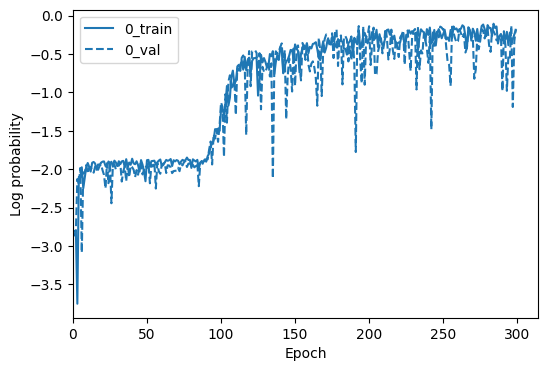

In [14]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m["training_log_probs"], ls="-", label=f"{i}_train", c=c[i])
    ax.plot(m["validation_log_probs"], ls="--", label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel("Epoch")
ax.set_ylabel("Log probability")
ax.legend()

100%|██████████| 100/100 [00:00<00:00, 142.75it/s]


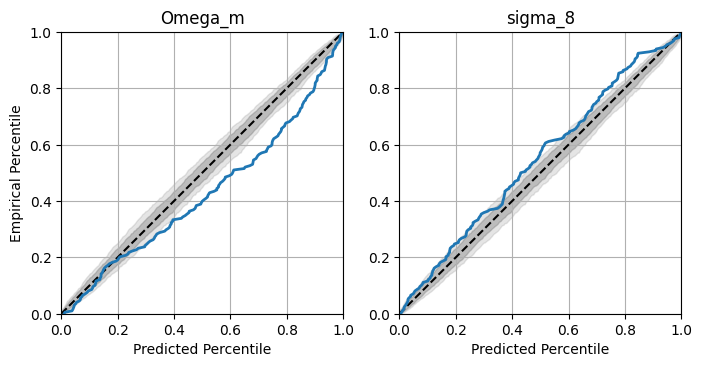

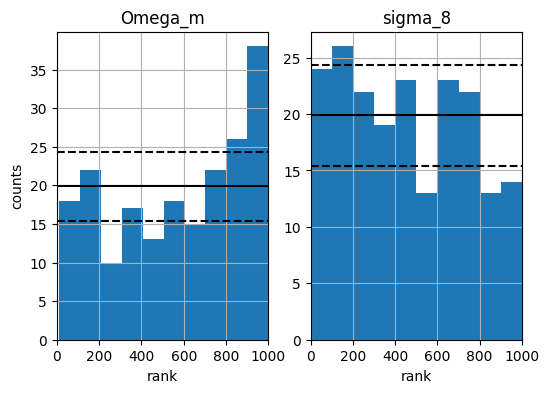

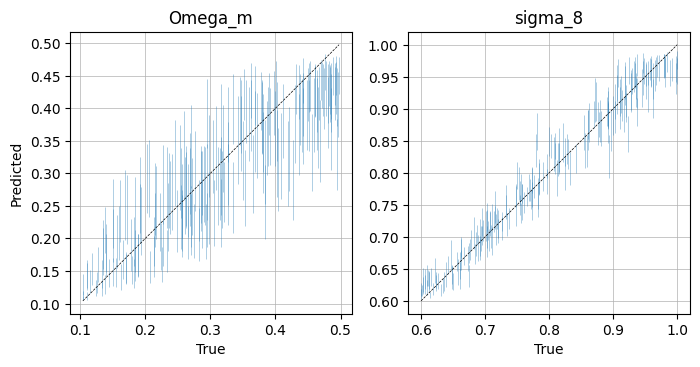

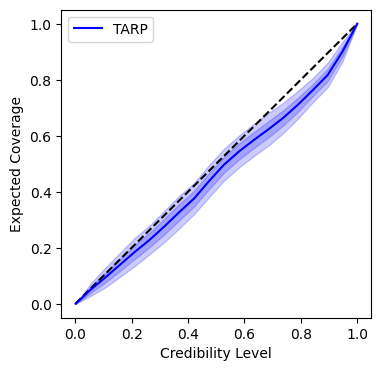

In [15]:


# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000,
    sample_method="direct",
    labels=param_names,
    plot_list=["coverage", "histogram", "predictions", "tarp"],
    out_dir=None,
)

fig = metric(
    posterior=posterior_ensemble,  # NeuralPosteriorEnsemble instance from sbi package
    x=val_dataset.data_list,
    theta=val_theta,
)

In [16]:
plot_priors = {'Omega_m': [0.1,0.5], 'sigma_8': [0.6,1.0]}
param_labels = ['\Omega_m', '\sigma_8']


INFO:root:Sampling models with tensor([1000.], device='cuda:0') samples each.
Drawing 1000 posterior samples: 1972it [00:00, 179987.98it/s]           


Removed no burn in


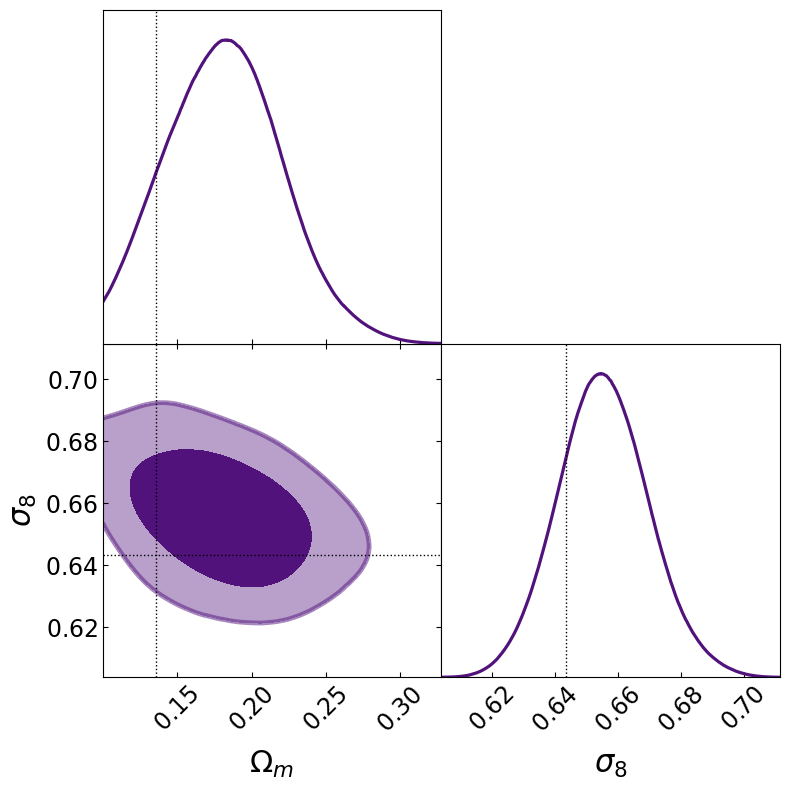

INFO:root:Sampling models with tensor([1000.], device='cuda:0') samples each.
Drawing 1000 posterior samples: 1993it [00:00, 146784.81it/s]           


Removed no burn in


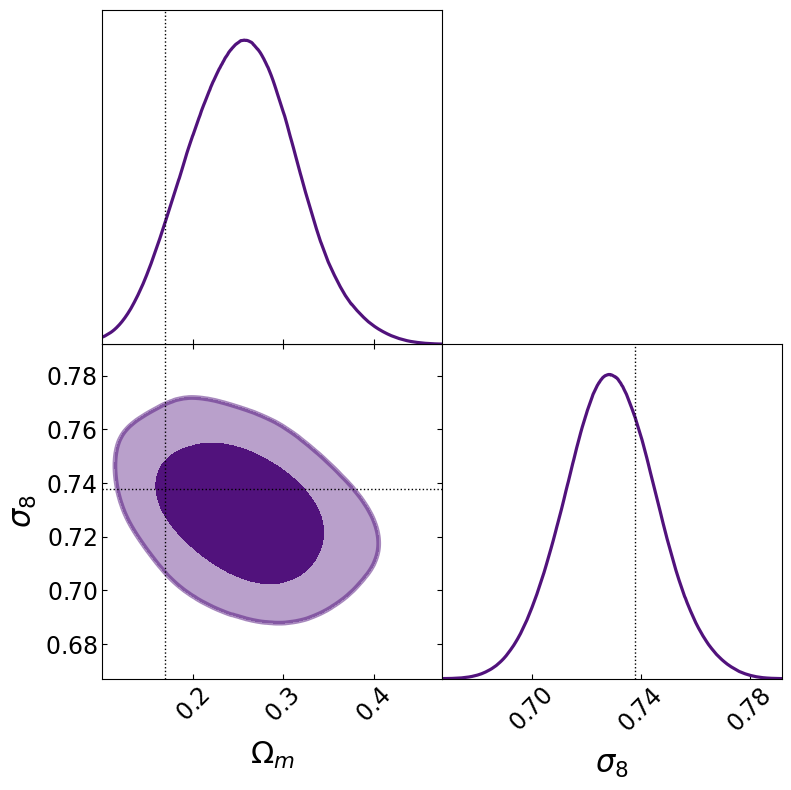

INFO:root:Sampling models with tensor([1000.], device='cuda:0') samples each.
Drawing 1000 posterior samples: 1993it [00:00, 181363.99it/s]           


Removed no burn in


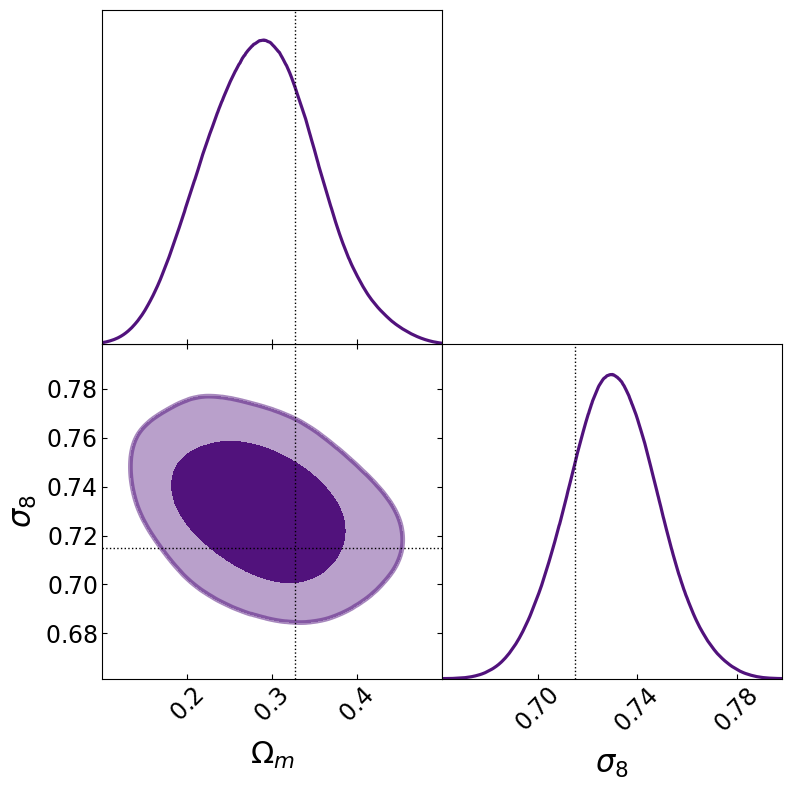

INFO:root:Sampling models with tensor([1000.], device='cuda:0') samples each.
Drawing 1000 posterior samples: 1940it [00:00, 183442.29it/s]           


Removed no burn in


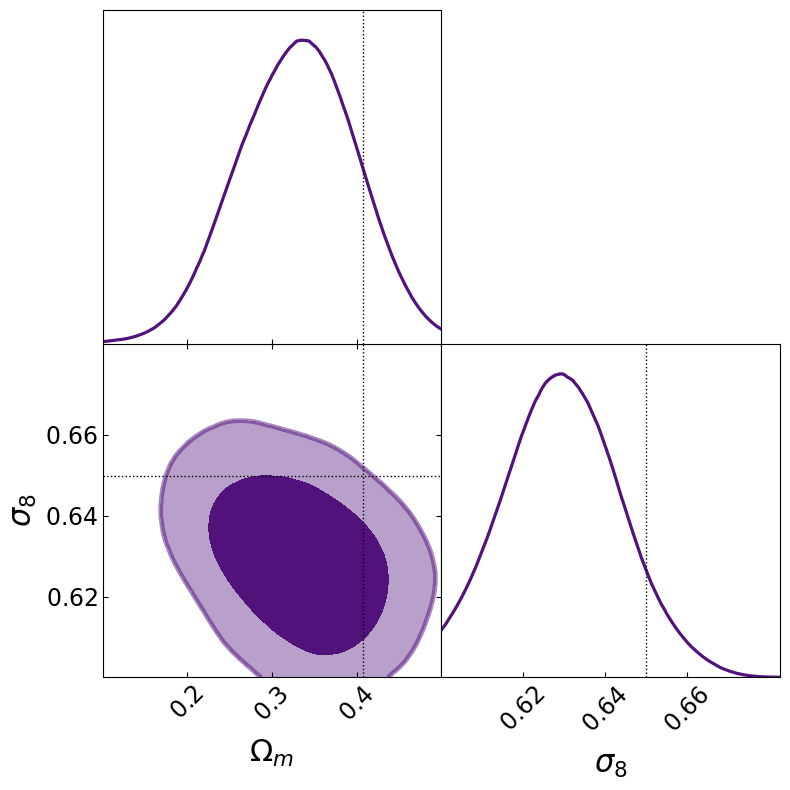

INFO:root:Sampling models with tensor([1000.], device='cuda:0') samples each.
Drawing 1000 posterior samples: 1882it [00:00, 177386.07it/s]           


Removed no burn in


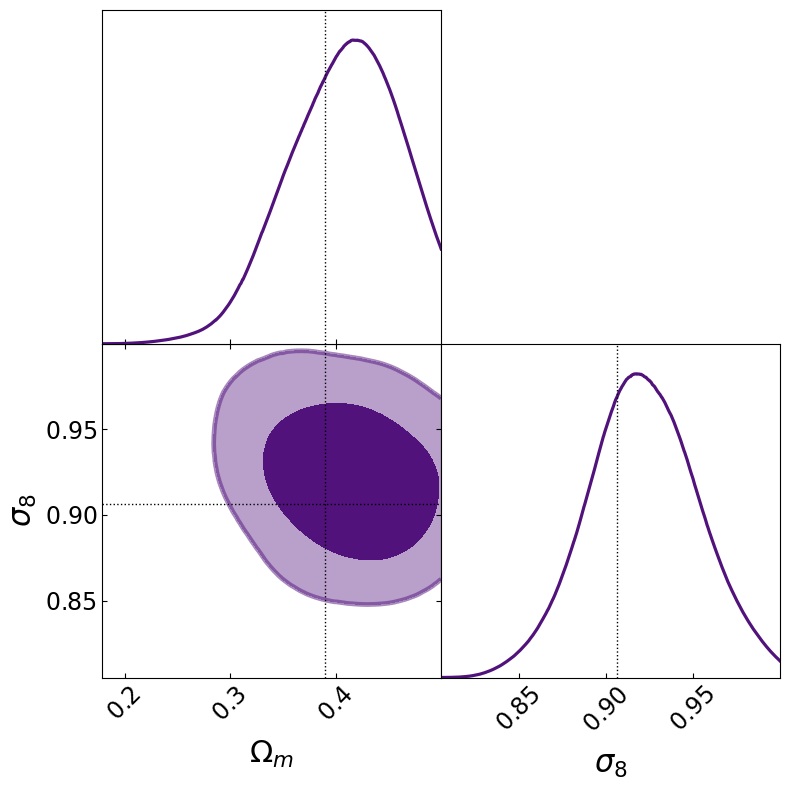

INFO:root:Sampling models with tensor([1000.], device='cuda:0') samples each.
Drawing 1000 posterior samples: 1926it [00:00, 170527.52it/s]           


Removed no burn in


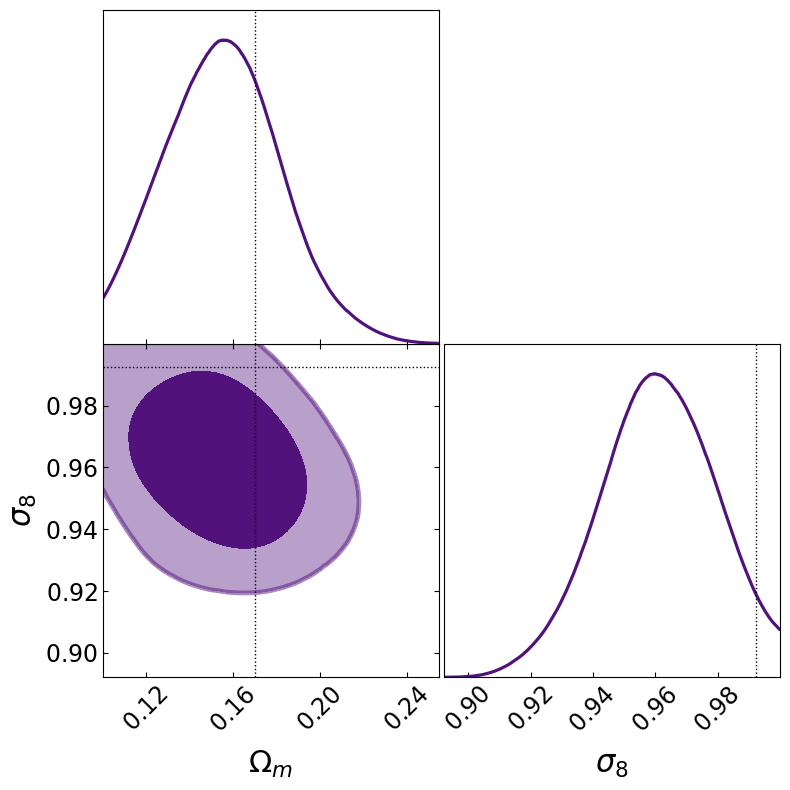

In [20]:
for i in range(6):
    x_ = val_dataset[i][0]
    y_ = val_dataset[i][1]
    dim_theta = y_.shape[-1]

    # generate samples from the posterior using accept/reject sampling
    seed_samp = 1234
    torch.manual_seed(seed_samp)
    samples = posterior_ensemble.sample((1000,), val_dataset[i][0])
    samples = MCSamples(
        samples=samples.detach().cpu().numpy(),
        names=param_names,
        labels=param_labels,
        ranges=plot_priors,
    )
    retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']


    g = plots.get_subplot_plotter(width_inch=8)
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_ls = ':'
    g.settings.title_limit_labels = False
    g.settings.axis_marker_color = 'k'
    g.settings.legend_colored_text = True
    g.settings.figure_legend_frame = False
    g.settings.linewidth = 2.0
    g.settings.linewidth_contour = 3.0
    g.settings.legend_fontsize = 22
    g.settings.axes_fontsize = 17
    g.settings.axes_labelsize = 22
    g.settings.axis_tick_x_rotation = 45
    g.settings.axis_tick_max_labels = 6
    g.settings.solid_colors = retro
    g.settings.solid_colors = ['#51127c']

    g.triangle_plot(
        roots=[samples],
        params=param_names,
        filled=True,
        markers=y_.detach().cpu().numpy(),
    )
    plt.savefig(f"posterior_{i}.pdf", bbox_inches="tight")
    plt.show()